In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from pytexit import py2tex
from IPython.display import Markdown
from gekko import GEKKO
import pandas as pd
from matplotlib import rcParams
import os
import sys
from copy import copy
from pytexit import py2tex


import sympy as sp
sp.init_printing()


%matplotlib widget
#%matplotlib inline

# Look for custom python codes in the Radigan Engineering Vault...
sys.path.insert(1, 'C:\\\\RadiganVault\\\\Python')

import RadiganEngineeringDefaults as RE
from RadiganEngineering_Materials_Library import *
from RadiganEngineeringTorsionSpring import *
from RadiganEngineeringBellevilleSpring import *

# Use higher quality figures in PDF exports
#rcParams['figure.dpi']= 300
#rcParams['figure.figsize'] = [8, 6]
set_matplotlib_formats('png', 'pdf')

print(ALUMINUM_6061_T6.Specific_Heat)

896 joule / kelvin / kilogram


'Convection Term:'

'Radiation Term:'

'Heat Gain Term:'

'Model Equation Right-Hand-Side:'

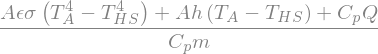

'Full Model Equation:'

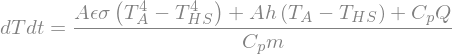

'Model partial derivitive with respect to "spT_HS":'

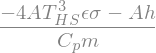

'Model partial derivitive with respect to "sp_Heater_Q":'

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\ProgramData\Anaconda3\lib\site-packages\gekko\gk_write_files.py:144: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  csv_data = np.hstack(('time',np.array(self.time).flatten().astype(object)))


In [7]:
# https://apmonitor.com/pdc/index.php/Main/TCLabSim
# https://apmonitor.com/pdc/index.php/Main/TCLabConvection

# Update model with natural convection estimation.

TCLab = GEKKO(remote=False)    # create GEKKO model for dx/dt

t_sim = 1500 * ureg.sec # Number of seconds to simulate
points_per_second = 1 # Only works if this is the same as the 'sampling frequency' in the cell below...

TCLab.time = np.linspace(0, t_sim.magnitude, (t_sim.magnitude * points_per_second) + 1) * ureg.sec # time points

# dt is in the units of ________.

# --> Inputs (7):
T_Ambient = 27.0  # * ureg.degree_Celsius # degC
T_Ambient_K = T_Ambient + 273.15
#T_Ambient = Q_(26.0, ureg.degC)
HS_Mass  = 0.004 * ureg.kg 
HS_Cp    = 500.0 * (ureg.joule /  (ureg.kg    * ureg.kelvin)) # Heatsink Specific Heat
HS_Conv  = 5.0   * (ureg.watt) / ((ureg.m**2) * ureg.kelvin)  # Convection coefficient
# NOTE: This lesson changes the convection coefficient from 10 to 5 W/m^2-K, in order to make a better match when including the RADIATION TERM.
HS_Area  = 0.0012 * ureg.m**2                                 # Heatsink Surface Area

sigma    = 5.67e-8 # W/m2-K4
epsilon  = 0.9

# Starting temperature for the heatsink.
# Might be equal to 'T_Ambient' or something else.
#HS_T_Start = T_Ambient
#HS_T_Start = Q_(28.0, ureg.degC)
HS_T_Start = 27.0 # degC

# Curve defining the heater setting over the course of time.
HeaterValues = np.zeros(len(TCLab.time))
HeaterValues[15:800] = 50
#HeaterValues[0:9] = 50
Heater_Q  = TCLab.Param(HeaterValues)  # "Percentage of maximum value" of the heater

C_p       = TCLab.Param(0.01)  # ~= 0.01 Watts / % # This seems a little low, I would have expected more than 1 Watt at full power [100%]

# --> States (1): (Variables, with initial conditions)
#print('Heatsink Starting Temperature is {0}'.format(HS_T_Start.to('degC').magnitude))
HS_Temp_C   = TCLab.Var(HS_T_Start) # GEKKO variable for the temperature of the heatsink

# --> Equations (1): 
HS_Temp_K  = TCLab.Intermediate(HS_Temp_C + 273.15) # Convert to Kelvin for the Radiation term
Convection = TCLab.Intermediate(  (HS_Conv.to('watt/(m^2*K)').magnitude * HS_Area.to('m^2').magnitude) * (T_Ambient_K - HS_Temp_K)  )
Radiation  = TCLab.Intermediate(  sigma * epsilon * HS_Area.to('m^2').magnitude * (T_Ambient_K**4 - HS_Temp_K**4)  )
Loss       = TCLab.Intermediate(Convection + Radiation)
Gain       = TCLab.Intermediate(C_p*Heater_Q)


# SymPy equations for the partial derivitives
sph,spArea,spT_Ambient,spT_HS = sp.symbols(['h','A','T_A','T_HS']) # Convection symbols
spConvection                  = (sph * spArea) * (spT_Ambient - spT_HS)
display('Convection Term:')
display(spConvection)

spsigma, spepsilon            = sp.symbols(['sigma','epsilon'])
spRadiation                   = spsigma * spepsilon * spArea * (spT_Ambient**4 - spT_HS**4)
display('Radiation Term:')
display(spRadiation)

spC_p, sp_Heater_Q            = sp.symbols(['C_p','Q'])
spGain                        = spC_p * sp_Heater_Q
display('Heat Gain Term:')
display(spGain)


# GEKKO model Equation
#TCLab.Equation(HS_Temp_C.dt()  == ( Convection + Radiation + (C_p * Heater_Q) ) / 
#                                (HS_Mass.to('kg').magnitude * HS_Cp.to('joule/(kg*K)').magnitude) )
TCLab.Equation(HS_Temp_C.dt()  == ( Convection + Radiation + Gain ) / 
                                (HS_Mass.to('kg').magnitude * HS_Cp.to('joule/(kg*K)').magnitude) )

# Sympy Equation
sp_mass,spHS_Temp_C  = sp.symbols(['m','dTdt'])
spTCModel =  (spConvection + spRadiation + spGain) / (sp_mass * spC_p)
display('Model Equation Right-Hand-Side:')
display(spTCModel)


# This is the 'super simple' method for printing the equation.
#py2tex('dTdt  = ( Convection + Radiation + Gain ) / (HS_Mass * HS_Cp)')

# A SymPy 'Equation' includes what is on both the RIGHT and LEFT hand side of the '='
spHS_Temp_C_display = sp.Eq(spHS_Temp_C, spTCModel )
display('Full Model Equation:')
display(spHS_Temp_C_display)

display('Model partial derivitive with respect to "spT_HS":')
display(sp.diff(spTCModel,spT_HS))

display('Model partial derivitive with respect to "sp_Heater_Q":')
display(sp.diff(spTCModel,sp_Heater_Q))



# solve ODEs and plot
# https://gekko.readthedocs.io/en/latest/imode.html
TCLab.options.IMODE = 4 # dynamic simulation


############### SOLVER OPTIONS ######################
# Type: Integer, Input/Output
# Default Value: 0
# Description: Cold start model: 0=warm start, 1=cold start, 2=decompose problem
#TCLab.options.COLDSTART = 2

#TCLab.options.SOLVER = 1
#TCLab.options.MAX_ITER = 1000

TCLab.options.NODES = 3
TCLab.options.TIME_SHIFT=0
############### SOLVER OPTIONS ######################


fig = plt.figure(figsize=(12,4))
plt_ax = plt.subplot(1,2,1)
#plt_ax = plt.axes(label='TCLab')
plt_ax.set_ylim(25,70)

# Solve the dynamic system
TCLab.solve(disp=False)

# Plot the heatsink temperature as a function of time. (And Heater input curve...)
plt_ax.plot(TCLab.time,HS_Temp_C, marker='',linewidth=1,label='C_p = {0}'.format(C_p.value[0]))


######################################################################################
# Create the 'dummy' plot with NaN's that will be replaced with measured data below.
T1 = np.empty(len(TCLab.time))
T1[:] = np.nan
T1_time = np.empty(len(TCLab.time))
T1_time[:] = np.nan
MeasuredData, = plt_ax.plot(T1_time,T1,'r.', label='Measured')
######################################################################################

plt.grid(True)
plt.title('TC Lab Thermal Simulation')
plt.xlabel('Time (sec)')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

# instantiate a second axes that shares the same x-axis and plot the Heater Input
Q_ax = plt_ax.twinx()  
Q_ax.plot(TCLab.time,Heater_Q, color = 'gray', linestyle = ':', marker='',linewidth=2,label='Heater')
Q_ax.set_ylim(-5,105)
plt.ylabel('Heater Percentage')
plt.legend(loc = 'lower right')

# Make a second plot that shows the heat Gain & Loss terms
plt_ax2 = plt.subplot(1,2,2)
plt_ax2.plot(TCLab.time,Convection, marker='',linewidth=1,label='Convection')
plt_ax2.plot(TCLab.time,Radiation,  marker='',linewidth=1,label='Radiation')
plt_ax2.plot(TCLab.time,Loss,       color = 'blue', linestyle = ':', marker='',linewidth=1,label='Total Loss')
plt_ax2.plot(TCLab.time,Gain,       marker='',linewidth=1,label='Heater Gain')
plt.title('TC Lab Heat Gain & Loss Terms')
plt.xlabel('Time (sec)')
plt.ylabel('Energy (Watts)')
plt.legend()
plt.grid(True)

plt.subplots_adjust(wspace = 0.4 )


In [ ]:
# Actual measured data
import tclab
import time

if (1):
    lab = tclab.TCLab()
    #T1 = [lab.T1] # Old-style list based plotting...
    
    # Static On / Off Heater control
    #lab.Q1(50)
    #print('Turning Heater on to {0}%'.format(HeaterValue))
    #lab.Q1(HeaterValue)
    
    # Use the array defined above to set the heater.
    lab.Q1(HeaterValues[0])

    T1[:] = np.nan       # Reset the measured temperatures to NaN's
    T1_time[:] = np.nan

    for i in range(len(TCLab.time)):
        time.sleep(1)
        lab.Q1(HeaterValues[i])
        #print(lab.T1)
        print('Time = {3} sec, T1 = {0}, T2 = {1}, Heater Set to {2}'.format(lab.T1, lab.T2, HeaterValues[i], i))
        T1[i] = lab.T1
        T1_time[i] = i
        MeasuredData.set_ydata(np.array(T1))
        MeasuredData.set_xdata(np.array(T1_time))
        plt_ax.set_title("{0} of {1} Points Measured".format(i+1,t_sim))
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.show()

    lab.close()
    plt.show()


In [ ]:
if (0): # Grab the current temperature from the TCLab if desired. (I.e. = 1)
    import tclab
    lab = tclab.TCLab()
    print('T1 = {0}, T2 = {1}'.format(lab.T1, lab.T2))
    print('T1 = {0}, T2 = {1}'.format(lab.T1, lab.T2))
    print('T1 = {0}, T2 = {1}'.format(lab.T1, lab.T2))
    lab.close()

In [ ]:
#lab.close()